# 1. Introduction



In this Jupyter notebook, we generate a model that's able to successfully predict whether a molecule will bind to a specific target. For the first iteration of this notebook, we'll focus on predicting whether or not molecules will bind to the 5-hydroxytryptamine receptors (5-HTR). We draw inspiration from the following paper: https://pdfs.semanticscholar.org/c108/970bcb96967af5f5ba2783738bd39e751725.pdf

Let's start by importing the necessary dependencies.

In [1]:
# Base packages
import os
import settings
import string
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
import matplotlib.pyplot as plt
from collections import Counter
from google.cloud import bigquery

# Scikit-learn/imb-learn packages
from imblearn.over_sampling import ADASYN
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# RDkit, a cheminformatics library
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Query analysis dataset

Our analysis dataset will be generated by querying the ChEMBL database. This database is publicly available through the Google Cloud Platform (GCP). To access this platform through Python, we need to configure our Python environment and define the location of the GCP credentials.

In [2]:
# Define relative paths
NOTEBOOKS = os.getcwd()
WKDIR = NOTEBOOKS.replace('/Notebooks', '')
DATA = WKDIR + '/Data'

# Define location of credentials and initialize client
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = WKDIR + "/" + settings.GOOGLE_CLOUD_CREDENTIALS
EBI_CHEMBL = "patents-public-data.ebi_chembl"
client = bigquery.Client()

Let's first define the specific targets whose binding profile we want to characterize with our model.

In [3]:
target_query = f"""
SELECT DISTINCT 
    pref_name
FROM 
    `{EBI_CHEMBL}.target_dictionary_24`
WHERE 
    pref_name like "%5-HT%"   AND
    organism = "Homo sapiens" AND
    target_type = "SINGLE PROTEIN"
"""
target_list = client.query(target_query).to_dataframe()
target_list

,pref_name
0,Serotonin 1a (5-HT1a) receptor
1,Serotonin 1d (5-HT1d) receptor
2,Serotonin 1b (5-HT1b) receptor
3,Serotonin 2a (5-HT2a) receptor
4,Serotonin 2c (5-HT2c) receptor
5,Serotonin 3a (5-HT3a) receptor
6,Serotonin 4 (5-HT4) receptor
7,Serotonin 2b (5-HT2b) receptor
8,Serotonin 1f (5-HT1f) receptor
9,Serotonin 7 (5-HT7) receptor


In order to measure the biological activity of a given molecule, researchers perform assays, or experimental procedures that attempt to characterize a particular behavior or quantify a specific property associated with the entity of interest. For the purposes of our model, we’re interested in assays that measure drug affinity, or the concentration of the drug needed to induce some sort of observable effect. Let’s first identify the most common measurements associated with binding assays.

In [4]:
ACTIVITIES = f"{EBI_CHEMBL}.activities_24"
ACT_LOOKUP = f"{EBI_CHEMBL}.activity_stds_lookup_24"
ASSAYS = f"{EBI_CHEMBL}.assays_24"
CMPD_STR = f"{EBI_CHEMBL}.compound_structures_24"
MOL_DICT = f"{EBI_CHEMBL}.molecule_dictionary_24"
TGT_DICT = f"{EBI_CHEMBL}.target_dictionary_24"

binding_act_qtext = f"""
SELECT
    act.standard_type        AS standard_type,
    COUNT(act.standard_type) AS count,
    act_std.definition       AS definition
FROM `{ACTIVITIES}` act
    INNER JOIN `{ASSAYS}`     assays  on assays.assay_id = act.assay_id
    INNER JOIN `{ACT_LOOKUP}` act_std on act_std.standard_type = act.standard_type
WHERE 
    assays.assay_type = "B" AND 
    act_std.standard_units = "nM"
GROUP BY 
    standard_type,
    definition
ORDER BY count DESC
"""
binding_act = client.query(binding_act_qtext).to_dataframe()
binding_act

,standard_type,count,definition
0,IC50,1151059,Concentration required for 50% inhibition
1,Ki,572328,Inhibition constant
2,Potency,245136,Concentration or dose required to elicit a spe...
3,Kd,76349,Dissociation constant
4,EC50,72629,Effective concentration for 50% activity
5,AC50,10584,Concentration required for 50% activity
6,Km,6573,Michaelis constant
7,Kb,2493,Equilibrium binding constant
8,MIC,1596,Minimum inhibitory concentration
9,GI50,583,Concentration required for 50% growth inhibition


These results seem to make sense. For example, EC50 (the fifth most common measurement in the table above) represents the concentration of a molecule needed to induce half the maximal response. A low EC50 implies that a small concentration of this molecule induces half the maximal observable response, which provides strong evidence that the molecule actually binds to the target of interest. Conversely, a high EC50 indicates that the molecule doesn’t display high affinity for the target.

In order to substatiate the analysis above, let's examine a few documents associated with these metrics and confirm that they reference the ability of a particular molecule to bind to a specific target. Note that our previous query was conditioned on `assay_type = "B"`. We can easily show that non-binding assays (e.g., functional assays) can also produce the affinity measurements defined above, so we instead instead condition the following query on these measurements.

In [5]:
# Convert the measurements above into a list, and remove solubility
measurements = binding_act['standard_type'].tolist()
measurements = measurements[:-1]

# Convert the measurements into a string for the SQL query
measurements_str = ', '.join(f"'{m}'" for m in measurements)

# Define and execute query
DOCUMENTS = f"{EBI_CHEMBL}.docs_24"
docs_nbind_qtext = f"""
SELECT DISTINCT
    assays.assay_type AS assay_type,
    act.standard_type AS standard_type,
    docs.title        AS title,
    docs.abstract     AS abstract
FROM `{DOCUMENTS}` docs
    INNER JOIN `{ASSAYS}` assays  on assays.doc_id = docs.doc_id
    INNER JOIN `{ACTIVITIES}` act on act.assay_id = assays.assay_id
WHERE
    assays.assay_type != "B"                  AND
    act.standard_type in ({measurements_str}) AND
    docs.title IS NOT NULL                    AND
    docs.abstract IS NOT NULL
ORDER BY
    assays.assay_type,
    act.standard_type
"""
docs_nbind = client.query(docs_nbind_qtext).to_dataframe()
docs_nbind.head()

,assay_type,standard_type,title,abstract
0,A,AC50,Exploration of the correlation between the str...,The hemolytic activity of a collection of 63 s...
1,A,AC50,Identification of biphenyl-based hybrid molecu...,With the aim of enhancing the structural compl...
2,A,AC50,"4-(3-Halo/amino-4,5-dimethoxyphenyl)-5-aryloxa...",New combretastatin A analogues featuring oxazo...
3,A,AC50,"Antitumor agents from bohemic acid complex, II...","Six anthracycline antitumor agents, marcellomy..."
4,A,AC50,Neuroprotective activity and evaluation of Hsp...,Alzheimer's disease (AD) neuropathology is cha...


The documents below indicate that we can use the affinity measurements to query the intended assays:

- ADME assay: https://www.ncbi.nlm.nih.gov/pubmed/19072652
- Functional assay: https://www.ncbi.nlm.nih.gov/pubmed/26555041
- Physicochemical assay: https://www.ncbi.nlm.nih.gov/pubmed/25752525
- Toxicity assay: https://www.ncbi.nlm.nih.gov/pubmed/27639365
- Unassigned assay: https://www.ncbi.nlm.nih.gov/pubmed/19699641

Having determined the measurements of interest, let's start by characterizing the binding profile of the serotonin 1a receptor.

In [6]:
ACTIVITIES = f"{EBI_CHEMBL}.activities_24"
ASSAYS = f"{EBI_CHEMBL}.assays_24"
CMPD_STR = f"{EBI_CHEMBL}.compound_structures_24"
MOL_DICT = f"{EBI_CHEMBL}.molecule_dictionary_24"
TGT_DICT = f"{EBI_CHEMBL}.target_dictionary_24"

analysis_qtext = f"""
SELECT DISTINCT
    mol_dict.chembl_id        AS mol_chembl_id,
    act.molregno              AS molregno,
    act.standard_type         AS standard_type,
    act.standard_relation     AS standard_relation,
    act.standard_value        AS standard_value,
    act.standard_units        AS standard_units,
    cmpd_str.canonical_smiles AS canonical_smiles,
    tgt_dict.chembl_id        AS tgt_chembl_id,
    tgt_dict.pref_name        AS tgt_name,
    assays.chembl_id          AS assay_chembl_id,
    assays.description        AS assay_desc
FROM `{ACTIVITIES}` act
    INNER JOIN `{MOL_DICT}` mol_dict ON mol_dict.molregno = act.molregno
    INNER JOIN `{ASSAYS}`   assays   ON assays.assay_id = act.assay_id
    INNER JOIN `{TGT_DICT}` tgt_dict ON tgt_dict.tid = assays.tid
    INNER JOIN `{CMPD_STR}` cmpd_str ON cmpd_str.molregno = act.molregno
WHERE
    act.standard_units = "nM"               AND
    act.standard_relation in ("<", "=")     AND
    act.potential_duplicate = '0'           AND
    assays.confidence_score >= '8'          AND
    tgt_dict.organism = "Homo sapiens"      AND
    tgt_dict.target_type = "SINGLE PROTEIN" AND
    tgt_dict.pref_name = "Serotonin 1a (5-HT1a) receptor" AND
    act.standard_type IN ({measurements_str})
"""
data = client.query(analysis_qtext).to_dataframe()

# Convert the standard value to a numeric variable
data['standard_value'] = pd.to_numeric(data['standard_value'])
data.head()

,mol_chembl_id,molregno,standard_type,standard_relation,standard_value,standard_units,canonical_smiles,tgt_chembl_id,tgt_name,assay_chembl_id,assay_desc
0,CHEMBL39,2214,EC50,=,43.00,nM,NCCc1c[nH]c2ccc(O)cc12,CHEMBL214,Serotonin 1a (5-HT1a) receptor,CHEMBL615461,Compound was tested for the inhibition of fors...
1,CHEMBL39,2214,EC50,=,10.00,nM,NCCc1c[nH]c2ccc(O)cc12,CHEMBL214,Serotonin 1a (5-HT1a) receptor,CHEMBL615463,Effect on forskolin stimulated adenylate cycla...
2,CHEMBL39,2214,EC50,=,1.00,nM,NCCc1c[nH]c2ccc(O)cc12,CHEMBL214,Serotonin 1a (5-HT1a) receptor,CHEMBL858881,Agonistic activity at human 5HT1A in CHO cells...
3,CHEMBL39,2214,EC50,=,0.70,nM,NCCc1c[nH]c2ccc(O)cc12,CHEMBL214,Serotonin 1a (5-HT1a) receptor,CHEMBL867818,Agonist activity assessed by stimulation of [3...
4,CHEMBL39,2214,EC50,=,15.33,nM,NCCc1c[nH]c2ccc(O)cc12,CHEMBL214,Serotonin 1a (5-HT1a) receptor,CHEMBL3872771,Agonist activity at 5-HT1A receptor (unknown o...


# 3. Handle duplicates and define target variable

There are 814 duplicate molecules, and there are 12 duplicate molecule-activity values. In order to handle the latter, we will simply drop the duplicates. In order to handle the former, we will keep the molecule associated with the lower activity value.

In [7]:
print("No. of duplicate molecules: " + str(data.duplicated(subset=['mol_chembl_id']).sum()))
print("No. of duplicate molecule-activity values: " + str(data.duplicated(subset=['mol_chembl_id', 'standard_value']).sum()))

# Handle duplicate molecule-activity values
data_nodup = data.drop_duplicates(subset=['mol_chembl_id', 'standard_value'], inplace=False)

# Handle duplicate molecules
assert data_nodup.duplicated(subset=['mol_chembl_id', 'standard_value']).sum()==0
data_nodup.sort_values(by=['standard_value', 'mol_chembl_id'], ascending=True, inplace=True)
data_nodup.drop_duplicates(subset=['mol_chembl_id'], keep='first', inplace=True)
assert data_nodup.duplicated(subset=['mol_chembl_id']).sum()==0

# Save out a dataset without duplicates
print("Data dimensions after removing duplicates: " + str(data_nodup.shape))

No. of duplicate molecules: 814
No. of duplicate molecule-activity values: 12
Data dimensions after removing duplicates: (3832, 11)


We assume that a molecule binds to the target if its activity value (i.e., the concentration needed to induce a response) is less than or equal to 100nM. This threshold is based on the activity threshold for GPCRs here: https://druggablegenome.net/ProteinFam

In [8]:
def set_active(row):
    active = 0
    if row['standard_value'] <= 100:
        active = 1
    return active

# Create the 'active' variable in both the duplicated and non-duplicated datasets
data['active'] = data.apply(lambda x: set_active(x), axis=1)
data_nodup['active'] = data_nodup.apply(lambda x: set_active(x), axis=1)

# Tabulate number of active and non-activte molecules
print(data_nodup['active'].value_counts())

# Save out the datasets as CSVs
data.to_csv(DATA + '/ChEMBL Activity data (5-HT1a).csv', index=False)
data_nodup.to_csv(DATA + '/ChEMBL Activity Data (5-HT1a, no dup).csv', index=False)

1    2481
0    1351
Name: active, dtype: int64


# 4. Feature engineering (fingerprinting)

The probability that a given molecule binds to a target is dependent on, among other factors, the structure of the molecule itself. We can encode the structures of the molecules in our datasets using circular fingerprints. Circular fingerprints flatten the 2-D molecule structure into a 1-D vector by exhaustively enumerating and hashing all circular fragments grown radially from each heavy atom of the molecule up to a given radius. Figure 1 below illustrates this algorithm:

**Figure 1: Circular fingerprints**

<img src="CircularEnumeration.png">

Source: https://docs.eyesopen.com/toolkits/python/graphsimtk/fingerprint.html

The circular fingerprints described above are generated using the Morgan algorithm. Other algorithms produce a bit vector describing the structure of a molecule using slightly different methodologies. For example, the RDKit-specific algorithm generates a fingerprint by identifying all subgraphs in the molecular within a particular range of sizes, hashes each subgraph to generate a raw bit ID, mods the raw bit ID to fit in the assigned fingerprint size, and then sets the corresponding bit. In addition, the Atom-Pair algorithm generates fingerprints by hashing the types, the number of bonds, and the topological distance between various pairs of heavy atoms. Lastly, the Topological Tortion algorithm generates fingerprints by identifying bond paths of four non-hydrogen atoms. The features of these four-path fragments, such as the number of π electrons of each atom, atomic type and number of non-hydrogen branches, are then calculated and stored in a bit vector.

The following function utilizes the `rdkit` package to create an M x N matrix encoding the fingerprints for an inputted list of compounds.

In [9]:
def generate_fp_matrix(compounds, algorithm, bit_length, radius=None):
    """Create an {M x N} matrix encoding the Morgan fingerprints for the inputted list of compounds.
    
    Keyword arguments:
    compounds  -- a list of the SMILES associated with M compounds for which to generate Morgan fingerprints 
    radius     -- the radius used to generate the Morgan fingerprint
    algorithm  -- the fingerprinting algorithm to use ("Morgan," "rdkit," "atom_pair," or "top_tortion")
    bit_length -- the number of bits N used to encode each fingerprint
    """
    try:
        algorithm in ["Morgan", "rdkit", "atom_pair", "top_tortion"]
    except:
        print("Invalid fingerprint algortithm")
    
    try:
        (algorithm=="morgan" and radius is not None) or (algorithm!="morgan")
    except:
        print("Define radius for Morgan fingerprint")
    
    # Define the dimensions of the Morgan matrix
    m = len(compounds)
    n = bit_length
    
    # Initialize a {1 x N} row
    fp_matrix = np.zeros((1, bit_length))
    
    # Iterate through the compounds and generate the fingerprint for each
    for c in range(0, m):
        cmpd_smile = compounds[c]
        try:
            mol = Chem.MolFromSmiles(cmpd_smile)
            if algorithm=="morgan":
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=bit_length)
            elif algorithm=="rdkit":
                fp = rdmolops.RDKFingerprint(mol, fpSize=bit_length)
            elif algorithm=="atom_pair":
                fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=bit_length)
            elif algorithm=="top_tortion":
                fp = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=bit_length)
            fp_vector = np.array([int(x) for x in list(fp.ToBitString())])
            fp_matrix = np.row_stack((fp_matrix, fp_vector))
        except:
            print(f"Unable to generate fingerprint for molecule {c}")
        
    # Delete the first row of zeros
    fp_matrix = np.delete(fp_matrix, 0, axis=0)
    
    # Return the matrix
    print(f"Finished generating fingerprints ({algorithm})!")
    return fp_matrix 

In [10]:
smiles = data_nodup['canonical_smiles'].tolist()
y = np.array(data_nodup['active'])
fp_morg = generate_fp_matrix(compounds=smiles, algorithm = "morgan", bit_length=1024, radius=2)
fp_rdkit = generate_fp_matrix(compounds=smiles, algorithm = "rdkit", bit_length=1024)
fp_atom = generate_fp_matrix(compounds=smiles, algorithm = "atom_pair", bit_length=1024)
fp_tt = generate_fp_matrix(compounds=smiles, algorithm = "top_tortion", bit_length=1024)

Finished generating fingerprints (morgan)!
Finished generating fingerprints (rdkit)!
Finished generating fingerprints (atom_pair)!
Finished generating fingerprints (top_tortion)!


# 5. Balancing the dataset

In our de-duplicated dataset, the distribution of classes is skewed positive. That is, approximately 2/3 of the data (2,481) are classified as "active" molecules, whereas the remaining 1/3 of the data (1,351) are classified as "inactive" molecules. This can influence the performance of our classification models, because many machine learning algorithms are sensitive to an unbalanced predictor classes. Therefore, in this section, we balance the classes.

One common method to do so is to resample the data. Resampling involves changing the composition of the dataset by either removing training examples from the overrepresented predictor class (undersampling) or to generate new data points for the underrepresented predictor class (oversampling). For the purposes of this exercise, we will oversample the data using the Synthetic Minority Over-sampling Technique algorithm. The SMOTE algorithm generates synthetic copies of the minority class by selecting the *k* nearest neighbors of a given point and generating instances along the line segments connecting these neighbors. More information can be found here: https://arxiv.org/pdf/1106.1813.pdf. The Adaptive Synthetic Sampling Approach (ADASYN) algorithm implements the SMOTE algorithm, but adds a small random value to increase the variance and simulate more realistic data.

In [11]:
# Resample the data using the ADASYN algorithm
ada = ADASYN(random_state = 42)
fp_morg_res, y_morg_res = ada.fit_resample(fp_morg, y)
fp_rdkit_res, y_rdkit_res = ada.fit_resample(fp_rdkit, y)
fp_atom_res, y_atom_res = ada.fit_resample(fp_atom, y)
fp_tt_res, y_tt_res = ada.fit_resample(fp_tt, y)

# Store in dictionary
fingerprints = {"morgan": [fp_morg_res, y_morg_res],
                "rdkit": [fp_rdkit_res, y_rdkit_res],
                "atom": [fp_atom_res, y_atom_res],
                "tt": [fp_tt_res, y_tt_res]}

# Dimensions of the one of the newly resampled datasets
print(f'Dimensions of resampled Morgan fingerprint data: {fp_morg_res.shape}')

Dimensions of resampled Morgan fingerprint data: (4830, 1024)


# 6. Generate predictive models

We will build three models: 1) a logistic regression model, 2) a KNN model, and 3) a gradient boosting algorithm. However, we first split the data into a training and testing dataset.

In [12]:
train_test = {}
for f in fingerprints.keys():
    features = fingerprints[f][0]
    target = fingerprints[f][1]
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)
    train_test[f] = [X_train, X_test, y_train, y_test]

We can assess the performance of our model on our test data using a confusion matrix. There are four components to this matrix:

1. True positives (TP): compounds that were predicted to effect the activity of 5-HT1a and actually do so
2. True negatives (TN): compounds that were predicted not to effect the activity of 5-HT1a and actually don't
3. False positives (FP): compounds that were predicted to effect the activity of 5-HT1a but actually don't (Type I error)
4. False negatives (FN): compounds that were predicted not to effect the activity of 5-HT1a but actually do (Type II error).

We can then use the confusion matrix above to generate an ROC curve and calculate the area underneath this curve (i.e., the AUC). The ROC plots the false positive rate (FPR) against the true positive rate (TPR), and the AUC captures the degree of separation between the two class distributions.

In [28]:
def plot_confusion_matrix(y_true, y_pred, normalize=True):
    """Plots the confusion matrix for a given set of predictions
    
    Keyword arguments:
    y_true    -- the true labels associated with the data
    y_pred    -- the predicted labels associated with the data
    normalize -- boolean specifying whether or not to normalize the matrix; default is set to True
    """
    # Generate list of unique classes
    classes = np.unique(y_true)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    
    # Normalize
    if normalize:
        title = "Normalized confusion matrix"
        totals = np.sum(cm, axis=1)
        cm_norm = []
        for i in range(0, len(totals)):
            cm_norm.append([x/totals[i] for x in cm[i]])
    else:
        title = "Confusion matrix"

    # Generate heatmap (current version of matplotlib broke heatmaps).
    df_cm = pd.DataFrame(cm_norm, index=classes, columns=classes)
    sns.heatmap(df_cm, annot=True)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)
    plt.show()

In [25]:
def plot_roc(clf, fps):
    """Plots the ROC-AUC curves for classifiers associated with the different fingerprints
    
    Keyword arguments:
    clf    -- binary classifier
    fps    -- dictionary containing the fingerprints and the associated datasets
    X_test -- the features associated with the test data
    y_test -- the true labels associated with the test data
    """
    for f in fps.keys():
        X_train = fps[f][0]
        X_test = fps[f][1]
        y_train = fps[f][2]
        y_test = fps[f][3]
        
        # There are two common functions used to generate the scores necessary to produce an ROC curve: 'decision_function,'
        # or 'predict_proba.' The 'decision_function' method directly produced a score for each classifier. The
        # 'predict_proba' method calculates the probability that a given observation will fall in either class. The ROC
        # curve requires scores, not probabilities. Therefore, we will use the former method if the classifier supports it;
        # if not, then we will use the positive class's probability as a proxy for the scores.
        clf.fit(X_train, y_train)
        if hasattr(clf, "decision_function"):
            scores = clf.decision_function(X_test)
        else:
            scores = clf.predict_proba(X_test)[:, 1]

        # Calculate the false positive rate, the true positive rate, and the AUC
        fpr, tpr, thresholds = roc_curve(y_test, scores)
        model_auc = auc(fpr, tpr)
        model_name = type(clf).__name__
        plt.plot(fpr, tpr, lw=2, label=f"{model_name}, {f}, AUC = %0.2f" % (model_auc))

    # Plot the curve associated with a classifier that randomly predicts the labels
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    # Specify axis limits and titles, and display plot
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

## 5a. Logistic regression

Logistic regression is a statistical model that uses the logistic function to model the outcome of a binary variable. In order to prevent overfitting, we will fit our model to the data use k-fold cross validation. This algorithm can be defined as follows:

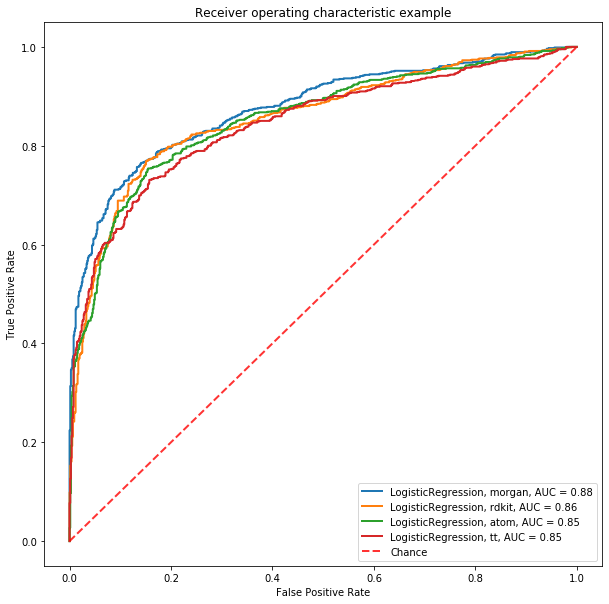

In [27]:
# Define the plot size
plt.rcParams["figure.figsize"] = (10,10)

# Instantiate the model and generate the ROC curves
lr = LogisticRegression()
plot_roc(lr, train_test)

The Morgan fingerprints produce the best AUC, albeit only slightly.